In [1]:
from importlib import reload
import utils_tf as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import IPython
import IPython.display
import matplotlib as mpl
import pandas as pd
import seaborn as sns

reload(u)

<module 'utils_tf' from 'c:\\Users\\Max\\OneDrive - National University of Singapore\\CentraleSupelec\\Networks for intelligent cities\\Project\\ST7_Forecasting_RTE\\utils_tf.py'>

Model here uses 50 data points to predict 1 data point into the future

In [2]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [3]:
wide_RNN_window = u.WindowGenerator(
    input_width=50, label_width=50, shift=1,
    label_columns=['y'])

In [4]:
history = u.compile_and_fit(lstm_model, wide_RNN_window)

val_performance = {}
performance = {}

val_performance['Single step'] = lstm_model.evaluate(wide_RNN_window.val, return_dict=True)
performance['Single step'] = lstm_model.evaluate(wide_RNN_window.test, verbose=0, return_dict=True)

Epoch 1/20
1917/1917 [==============================] - 40s 19ms/step - loss: 0.0307 - root_mean_squared_error: 0.1751 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 2/20
1917/1917 [==============================] - 51s 27ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 3/20
1917/1917 [==============================] - 40s 21ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 4/20
1917/1917 [==============================] - 40s 21ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 5/20
1917/1917 [==============================] - 40s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 6/20
1917/1917 [==============================] - 41s 21ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 -

In [5]:
#Saving model as h5 file so it can be loaded at anytime
lstm_model.save("lstm_model_single_step.h5")

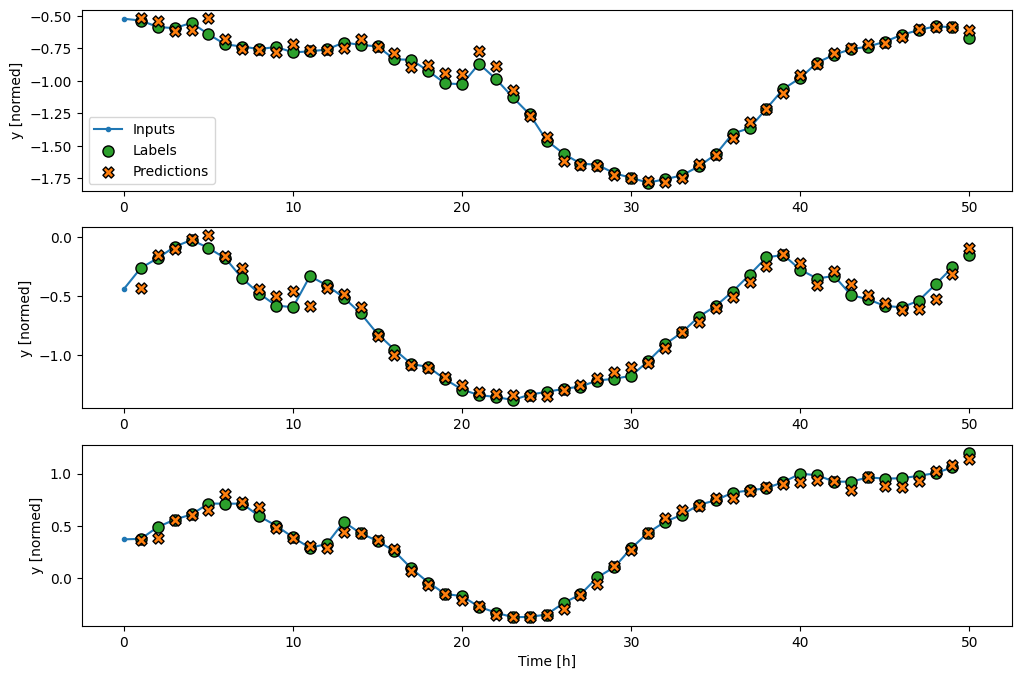

In [6]:
wide_RNN_window.plot(lstm_model)

Model here uses 50 data points (25 hours) to predict 50 datapoints into the future in one-shot

In [7]:
OUT_STEPS = 50
num_features = 1
multi_window = u.WindowGenerator(input_width=50,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

Epoch 1/20
1916/1916 [==============================] - 47s 23ms/step - loss: 0.1764 - root_mean_squared_error: 0.4200 - val_loss: 0.0761 - val_root_mean_squared_error: 0.2759
Epoch 2/20
1916/1916 [==============================] - 44s 23ms/step - loss: 0.0761 - root_mean_squared_error: 0.2758 - val_loss: 0.0864 - val_root_mean_squared_error: 0.2940
Epoch 3/20
1916/1916 [==============================] - 44s 23ms/step - loss: 0.0639 - root_mean_squared_error: 0.2529 - val_loss: 0.0710 - val_root_mean_squared_error: 0.2664
Epoch 4/20
1916/1916 [==============================] - 42s 22ms/step - loss: 0.0584 - root_mean_squared_error: 0.2416 - val_loss: 0.0766 - val_root_mean_squared_error: 0.2768
Epoch 5/20
1916/1916 [==============================] - 42s 22ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2693
Epoch 6/20
1916/1916 [==============================] - 45s 23ms/step - loss: 0.0525 - root_mean_squared_error: 0.2292 -

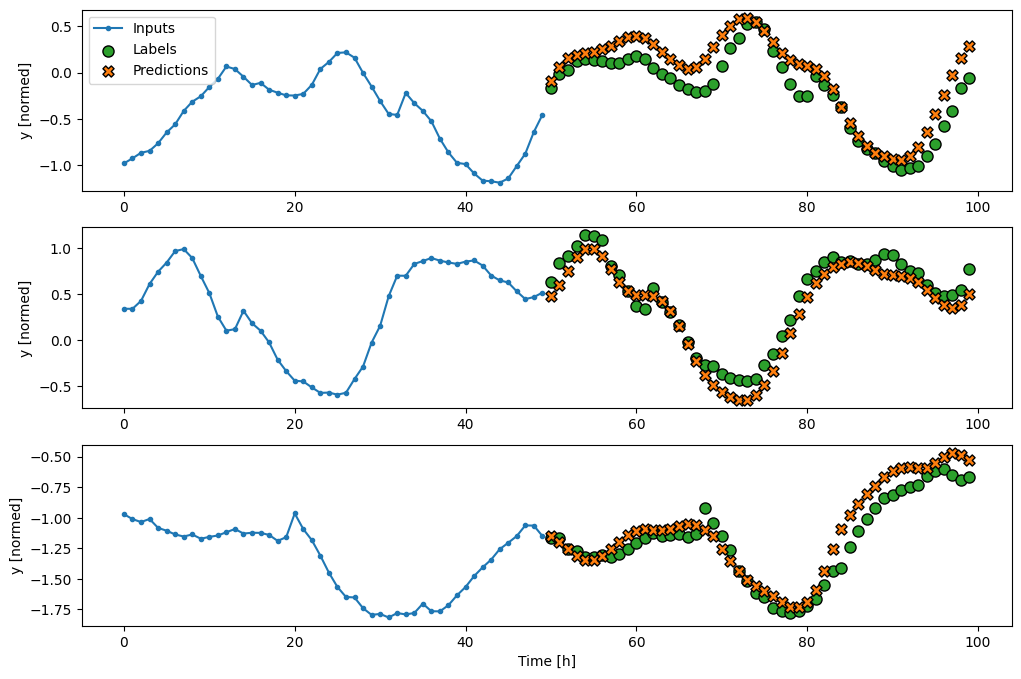

In [8]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = u.compile_and_fit(multi_lstm_model, multi_window)

val_performance['One-shot'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
performance['One-shot'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)


In [9]:
#Saving model as h5 file so it can be loaded at anytime
multi_lstm_model.save("lstm_model_multi_step.h5")

Autoregressive model that takes its own predictions as inputs

In [10]:
feedback_model = u.FeedBack(units=32, out_steps=OUT_STEPS)

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

545/545 [==============================] - 8s 14ms/step - loss: 0.0863 - root_mean_squared_error: 0.2938


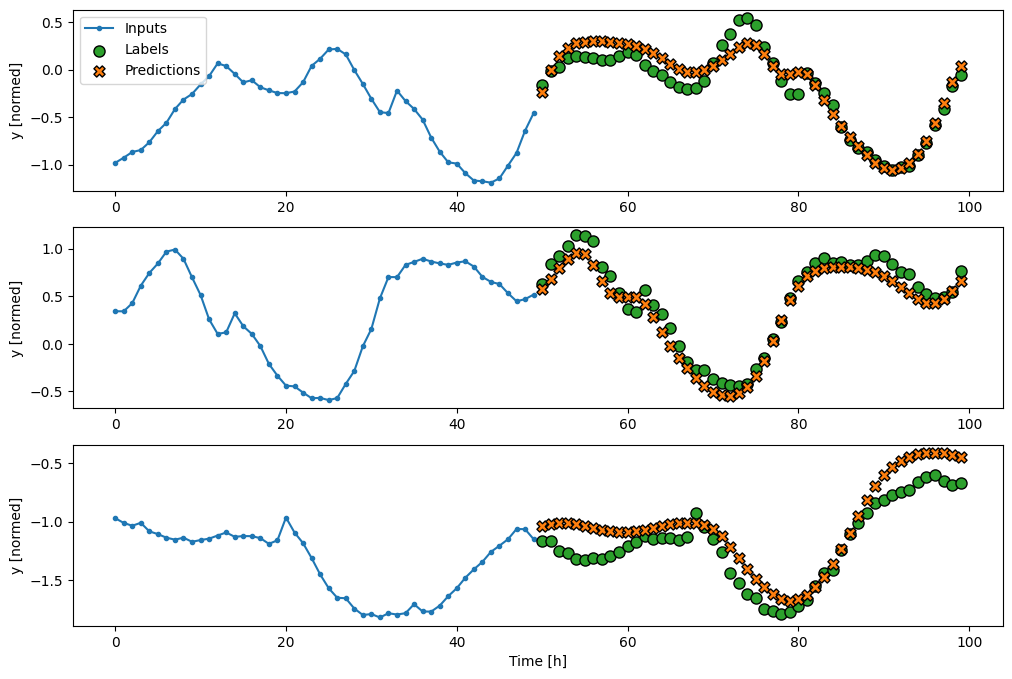

In [11]:
history = u.compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

val_performance['AR'] = feedback_model.evaluate(multi_window.val, return_dict=True)
performance['AR'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

In [12]:
single_lstm_model = keras.models.load_model("lstm_model_single_step.h5")
multi_lstm_model = keras.models.load_model("lstm_model_multi_step.h5")

Comparing error distribution between the 3 models

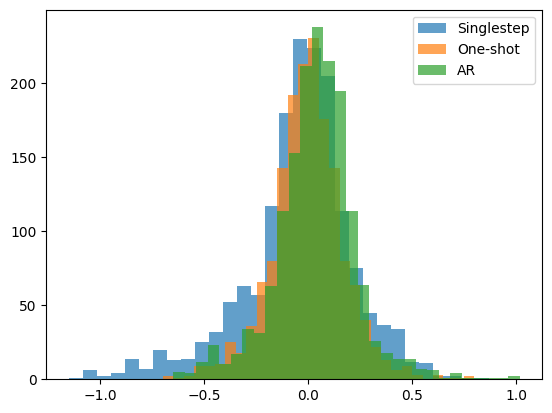

In [13]:
multi_window.compare_error_hist(models = [single_lstm_model,multi_lstm_model,feedback_model],label = ['Singlestep','One-shot','AR'])

In [14]:
performance

{'Single step': {'loss': 0.002378978533670306,
  'root_mean_squared_error': 0.04877476766705513},
 'One-shot': {'loss': 0.0420750230550766,
  'root_mean_squared_error': 0.2051219642162323},
 'AR': {'loss': 0.05691864341497421,
  'root_mean_squared_error': 0.2385762482881546}}

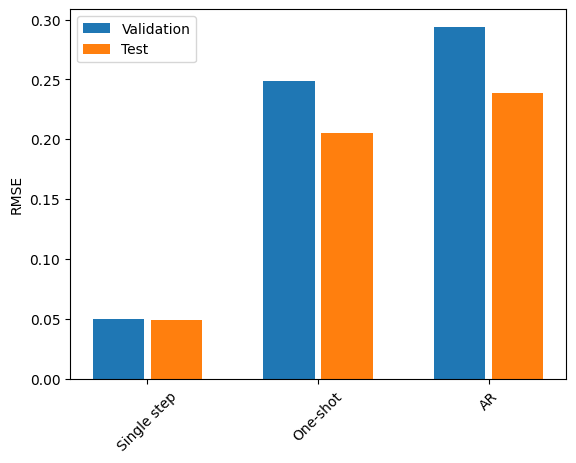

In [15]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'root_mean_squared_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'RMSE')
_ = plt.legend()

In [16]:
performance

{'Single step': {'loss': 0.002378978533670306,
  'root_mean_squared_error': 0.04877476766705513},
 'One-shot': {'loss': 0.0420750230550766,
  'root_mean_squared_error': 0.2051219642162323},
 'AR': {'loss': 0.05691864341497421,
  'root_mean_squared_error': 0.2385762482881546}}

In [17]:
val_performance

{'Single step': {'loss': 0.002484322525560856,
  'root_mean_squared_error': 0.049842990934848785},
 'One-shot': {'loss': 0.062005020678043365,
  'root_mean_squared_error': 0.2490081489086151},
 'AR': {'loss': 0.086322121322155,
  'root_mean_squared_error': 0.293806254863739}}